In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType


In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .config("spark.driver.memory", "4g") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/25 09:50:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Datasets
- user_logs.csv — contain data from 2015/01/01 - 2017/02/28
- user_logs_v2.csv — contain data from 2017/03/01 - 2017/03/31
- transactions.csv — (transaction_date) 2015/01/01 - 2017/02/28
- transactions_v2.csv — (transaction_date) 2015/01/01 - 2017/03/31 (has lesser rows tho ??)
- members_v3.csv — 6mill members
- train.csv — contains user ids and whether they have churned.
- train_v2.csv — contains the churn data for March, 2017.


# User Logs

In [27]:

df = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .parquet("datamart/bronze/user_logs/year=2015/month=01"))


In [28]:
df.cache()

DataFrame[msno: string, date: int, num_25: int, num_50: int, num_75: int, num_985: int, num_100: int, num_unq: int, total_secs: double]

In [29]:
df.show()

+--------------------+--------+------+------+------+-------+-------+-------+----------+
|                msno|    date|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+--------+------+------+------+-------+-------+-------+----------+
|C4StQg63rttGAOqto...|20150120|     2|     2|     1|      0|      6|      9|  1699.446|
|8lZ3LnlnX1kWyKkGt...|20150109|     5|     2|     1|      0|     82|     55| 17811.605|
|GCqC99i1NrtvDGMkx...|20150129|     2|     1|     0|      1|    129|      4| 34703.904|
|Dnpj5VLwwN5mUR8HA...|20150128|     0|     0|     0|      1|      7|      7|  2162.177|
|l1PoAgkJoUkdBz9aH...|20150112|     2|     0|     0|      0|     34|     27|  9284.661|
|xrIHhq+6/NnEwklQp...|20150120|     4|     1|     1|      1|    161|    115| 40552.138|
|9iUqNqp4tOo/Gu+dk...|20150115|    20|     6|     1|      5|     30|     21|  9404.582|
|fkYsxuAJ0fyDu8wqj...|20150107|     2|     0|     0|      0|     36|     32|  8196.252|
|vEB1w4iqIf3SvU37X...|20150106| 

## Check datatypes

In [30]:
# Show basic info
df.printSchema()
df.describe().show()


root
 |-- msno: string (nullable = true)
 |-- date: integer (nullable = true)
 |-- num_25: integer (nullable = true)
 |-- num_50: integer (nullable = true)
 |-- num_75: integer (nullable = true)
 |-- num_985: integer (nullable = true)
 |-- num_100: integer (nullable = true)
 |-- num_unq: integer (nullable = true)
 |-- total_secs: double (nullable = true)



[Stage 126:==================================================>    (12 + 1) / 13]

+-------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+--------------------+
|summary|                msno|                date|            num_25|            num_50|            num_75|          num_985|           num_100|          num_unq|          total_secs|
+-------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+--------------------+
|  count|            12897706|            12897706|          12897706|          12897706|          12897706|         12897706|          12897706|         12897706|            12897706|
|   mean|                NULL|2.0150116058964904E7| 6.098357645925562|1.6608211568785953|1.0136063731023175|1.201276257964013|31.652541157318982|29.88532697209876|-2.14534248473938...|
| stddev|                NULL|   8.908351254388021|13.421142334833364| 4.31

Issues: 
- Date is an integer
- the max for each column is too big
- the total seconds have negative values

### Outlier and Distribution Summary for Numeric Columns

This cell computes key statistics for each numeric feature to help identify potential outliers and understand the data distribution.

For every column (`num_25`, `num_50`, `num_75`, `num_985`, `num_100`, `num_unq`, `total_secs`), it calculates:
- **Minimum (`_min`)** – the smallest value in the column  
- **Median (`_median`)** – the 50th percentile, showing the central tendency  
- **99th Percentile (`_p99`)** – a robust upper-bound indicator to detect extreme outliers  
- **Maximum (`_max`)** – the largest observed value  

By comparing `_p99` and `_max`, we can see how far the extreme values stretch beyond typical behavior.  
Large gaps between these two suggest the presence of **outliers or corrupted data entries**.

In [31]:
from pyspark.sql.functions import col, count, isnan, min, max, percentile_approx
for c in ["num_25", "num_50", "num_75", "num_985", "num_100", "num_unq", "total_secs"]:
    df.select(
        min(col(c)).alias(f"{c}_min"),
        percentile_approx(col(c), 0.5).alias(f"{c}_median"),
        percentile_approx(col(c), 0.99).alias(f"{c}_p99"),
        max(col(c)).alias(f"{c}_max")
    ).show()

+----------+-------------+----------+----------+
|num_25_min|num_25_median|num_25_p99|num_25_max|
+----------+-------------+----------+----------+
|         0|            2|        58|     11328|
+----------+-------------+----------+----------+



+----------+-------------+----------+----------+
|num_50_min|num_50_median|num_50_p99|num_50_max|
+----------+-------------+----------+----------+
|         0|            1|        16|       841|
+----------+-------------+----------+----------+



+----------+-------------+----------+----------+
|num_75_min|num_75_median|num_75_p99|num_75_max|
+----------+-------------+----------+----------+
|         0|            0|         8|       373|
+----------+-------------+----------+----------+



+-----------+--------------+-----------+-----------+
|num_985_min|num_985_median|num_985_p99|num_985_max|
+-----------+--------------+-----------+-----------+
|          0|             0|         11|       1636|
+-----------+--------------+-----------+-----------+



+-----------+--------------+-----------+-----------+
|num_100_min|num_100_median|num_100_p99|num_100_max|
+-----------+--------------+-----------+-----------+
|          0|            16|        188|      34696|
+-----------+--------------+-----------+-----------+



+-----------+--------------+-----------+-----------+
|num_unq_min|num_unq_median|num_unq_p99|num_unq_max|
+-----------+--------------+-----------+-----------+
|          1|            18|        158|       1694|
+-----------+--------------+-----------+-----------+



[Stage 147:==================================================>    (12 + 1) / 13]

+--------------------+-----------------+--------------+----------------+
|      total_secs_min|total_secs_median|total_secs_p99|  total_secs_max|
+--------------------+-----------------+--------------+----------------+
|-9.22337203685156...|         4642.374|      46690.05|1.420659527338E9|
+--------------------+-----------------+--------------+----------------+



only a handful of data is corrupted

Remove negative values from total sec

In [34]:
df.filter(col("total_secs") < 0).show(10)

+--------------------+--------+------+------+------+-------+-------+-------+--------------------+
|                msno|    date|num_25|num_50|num_75|num_985|num_100|num_unq|          total_secs|
+--------------------+--------+------+------+------+-------+-------+-------+--------------------+
|T4wnYowN3mabEGttj...|20150108|    38|    23|     5|      1|     41|    102|-9.22337203684098...|
|txa9nJLmjzY2RlrU4...|20150123|     6|     1|     0|      4|     96|     63|-9.22337203682871...|
|8iC+wFW+Q+XzOaD7i...|20150101|     2|    11|     7|      1|      4|     23|-9.22337203685156...|
+--------------------+--------+------+------+------+-------+-------+-------+--------------------+



In [35]:
# Remove rows with negative total_secs
df = df.filter(col("total_secs") >= 0)

## Check for outliers

num_25: outliers = 1099579, fences -> lower=-10.5, upper=17.5


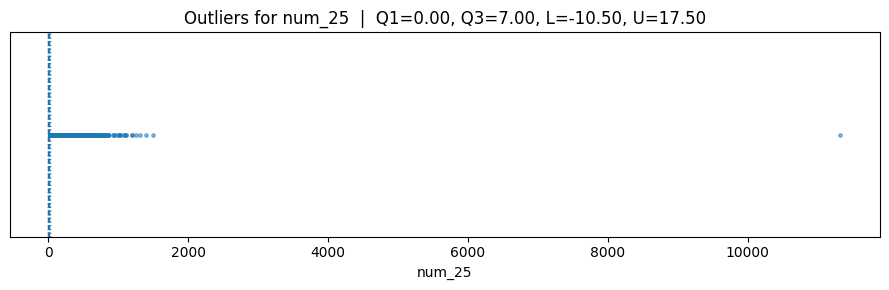

num_50: outliers = 848566, fences -> lower=-3.0, upper=5.0


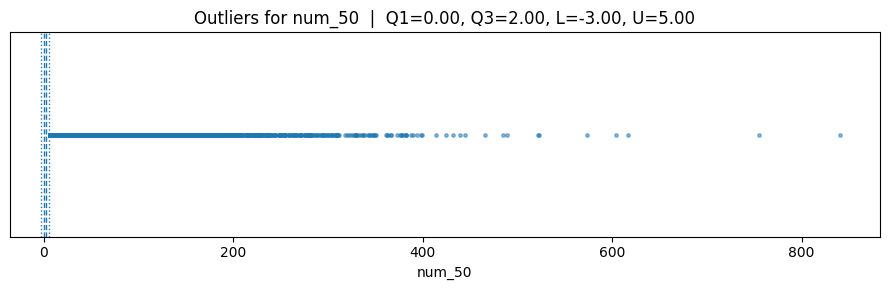

num_75: outliers = 1510848, fences -> lower=-1.5, upper=2.5


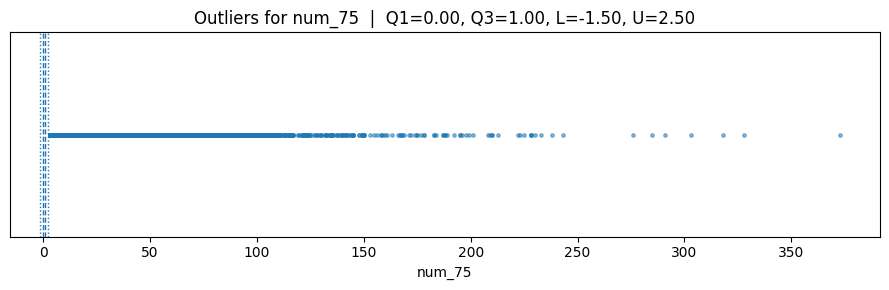

num_985: outliers = 1759702, fences -> lower=-1.5, upper=2.5


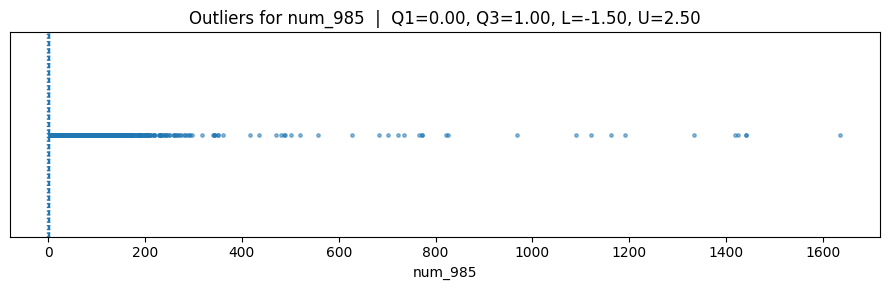

num_100: outliers = 1108016, fences -> lower=-45.0, upper=91.0


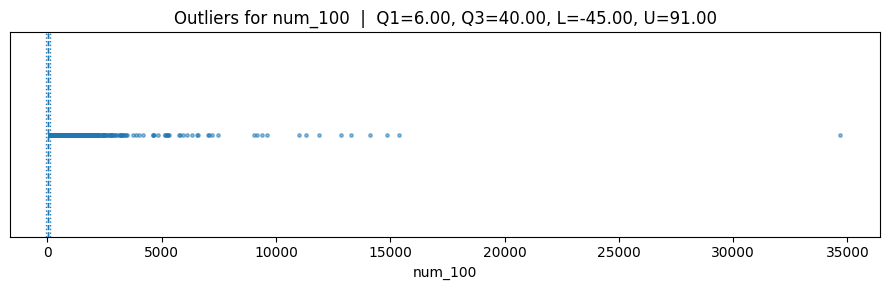

num_unq: outliers = 865402, fences -> lower=-42.5, upper=89.5


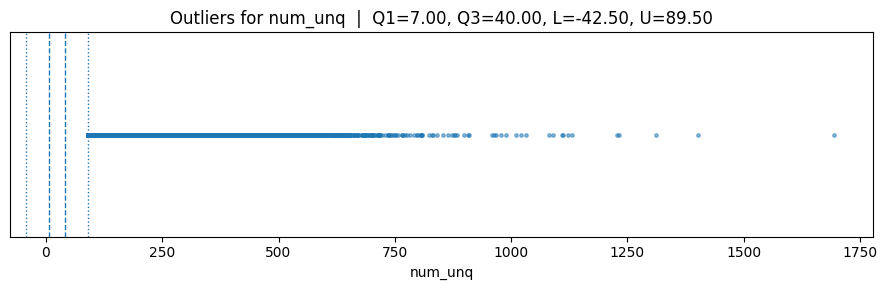

total_secs: outliers = 1073894, fences -> lower=-11842.704999999998, upper=24429.894999999997


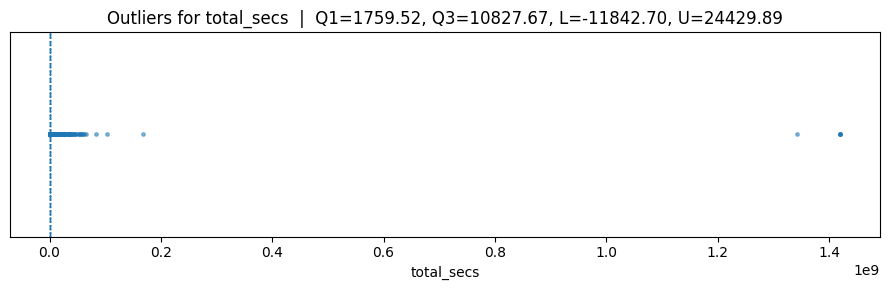

In [36]:
# --- PySpark: compute outliers (no sampling) and plot them separately ---
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Columns to check
cols = ["num_25","num_50","num_75","num_985","num_100","num_unq","total_secs"]

# (Optional) ensure date typed correctly
# from pyspark.sql.functions import to_date
# df = df.withColumn("date", to_date(col("date").cast("string"), "yyyyMMdd"))

def fences_for(colname):
    # approxQuantile is exact enough and scalable; probError=0.001 keeps it tight
    q1, q3 = df.approxQuantile(colname, [0.25, 0.75], 0.001)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return q1, q3, iqr, lower, upper

for c in cols:
    q1, q3, iqr, lower, upper = fences_for(c)

    # Filter TRUE outliers only (no sampling)
    out_df = df.select("msno", "date", c).where((col(c) < lower) | (col(c) > upper))

    # If there are no outliers, just print and continue
    out_count = out_df.count()
    print(f"{c}: outliers = {out_count}, fences -> lower={lower}, upper={upper}")

    if out_count == 0:
        continue

    # Bring only outliers to driver for plotting
    pdf = out_df.toPandas()  # only outlier rows

    # ---- Plot separately per column ----
    plt.figure(figsize=(9, 3))
    # Plot outlier values as a 1D scatter (strip) along x-axis
    plt.scatter(pdf[c], [1]*len(pdf), s=6, alpha=0.5)

    # Draw IQR box region and fences as reference
    plt.axvline(q1, linestyle="--", linewidth=1)
    plt.axvline(q3, linestyle="--", linewidth=1)
    plt.axvline(lower, linestyle=":", linewidth=1)
    plt.axvline(upper, linestyle=":", linewidth=1)

    plt.yticks([])  # cosmetic
    plt.xlabel(c)
    plt.title(f"Outliers for {c}  |  Q1={q1:.2f}, Q3={q3:.2f}, L={lower:.2f}, U={upper:.2f}")
    # Uncomment to help with huge ranges like total_secs:
    # plt.xscale("log")
    plt.tight_layout()
    plt.show()



## Remove Outliers

In [40]:
from pyspark.sql.functions import col

# Columns to clean
cols = ["num_25","num_50","num_75","num_985","num_100","num_unq", "total_secs"]

def fences_for(colname):
    q1, q3 = df.approxQuantile(colname, [0.25, 0.75], 0.001)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return lower, upper

# Build filter condition to keep only rows within valid ranges for all columns
condition = None
for c in cols:
    lower, upper = fences_for(c)
    cond = (col(c) >= lower) & (col(c) <= upper)
    condition = cond if condition is None else (condition & cond)
    print(f"{c}: keeping values between {lower:.2f} and {upper:.2f}")

# Apply filter
df_clean = df.filter(condition)

print("Before cleaning:", df.count())
print("After cleaning:", df_clean.count())


num_25: keeping values between -10.50 and 17.50


num_50: keeping values between -3.00 and 5.00


num_75: keeping values between -1.50 and 2.50


num_985: keeping values between -1.50 and 2.50


num_100: keeping values between -45.00 and 91.00


num_unq: keeping values between -42.50 and 89.50


total_secs: keeping values between -11842.70 and 24429.89
Before cleaning: 12897703
After cleaning: 9147620


In [41]:
df_clean.describe().show()

[Stage 505:==================================================>    (12 + 1) / 13]

+-------+--------------------+--------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+
|summary|                msno|                date|            num_25|            num_50|            num_75|            num_985|           num_100|           num_unq|        total_secs|
+-------+--------------------+--------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+
|  count|             9147620|             9147620|           9147620|           9147620|           9147620|            9147620|           9147620|           9147620|           9147620|
|   mean|                NULL|2.0150116072051965E7| 2.499145023514313|0.6657413622341112|0.4051955590634504|0.42444067418629106|18.251988386050144| 17.12490429204536| 4796.136464328834|
| stddev|                NULL|    8.90529474588174|3.3854240951778447|

Looks clean

In [47]:
from pyspark.sql.functions import col

# Check for negative values in any of the numeric columns
negative_counts = df_clean.where(
    (col("num_25") < 0) |
    (col("num_50") < 0) |
    (col("num_75") < 0) |
    (col("num_985") < 0) |
    (col("num_100") < 0) |
    (col("num_unq") < 0) |
    (col("total_secs") < 0)
).count()

print(f"Found {negative_counts} rows with negative numeric values.")

# Check for listening times that are impossibly long (more than 24 hours)
impossible_time_count = df_clean.where(col("total_secs") > 86400).count()
print(f"Found {impossible_time_count} rows where total_secs exceeds 24 hours.")

Found 0 rows with negative numeric values.
Found 0 rows where total_secs exceeds 24 hours.


In [50]:
from pyspark.sql import functions as F

dups = (
    df_clean.groupBy("msno", "date")
      .agg(F.count(F.lit(1)).alias("row_count"))
      .filter(F.col("row_count") > 1)
)


print("Duplicate (msno, date) pairs:", dups.count())


[Stage 558:==================================================>    (12 + 1) / 13]

Duplicate (msno, date) pairs: 0


### Change date column to date type

In [51]:
df_clean.printSchema()

root
 |-- msno: string (nullable = true)
 |-- date: integer (nullable = true)
 |-- num_25: integer (nullable = true)
 |-- num_50: integer (nullable = true)
 |-- num_75: integer (nullable = true)
 |-- num_985: integer (nullable = true)
 |-- num_100: integer (nullable = true)
 |-- num_unq: integer (nullable = true)
 |-- total_secs: double (nullable = true)



In [53]:
from pyspark.sql.functions import to_date, col
df_clean = df_clean.withColumn("date", to_date(col("date").cast("string"), "yyyyMMdd"))

In [55]:
df_clean.printSchema()

root
 |-- msno: string (nullable = true)
 |-- date: date (nullable = true)
 |-- num_25: integer (nullable = true)
 |-- num_50: integer (nullable = true)
 |-- num_75: integer (nullable = true)
 |-- num_985: integer (nullable = true)
 |-- num_100: integer (nullable = true)
 |-- num_unq: integer (nullable = true)
 |-- total_secs: double (nullable = true)



In [56]:
df.select("msno", "date").show(10)

+--------------------+--------+
|                msno|    date|
+--------------------+--------+
|C4StQg63rttGAOqto...|20150120|
|8lZ3LnlnX1kWyKkGt...|20150109|
|GCqC99i1NrtvDGMkx...|20150129|
|Dnpj5VLwwN5mUR8HA...|20150128|
|l1PoAgkJoUkdBz9aH...|20150112|
|xrIHhq+6/NnEwklQp...|20150120|
|9iUqNqp4tOo/Gu+dk...|20150115|
|fkYsxuAJ0fyDu8wqj...|20150107|
|vEB1w4iqIf3SvU37X...|20150106|
|ccqIvziyLZs/Ivbob...|20150110|
+--------------------+--------+
only showing top 10 rows



In [57]:
df.show()

+--------------------+--------+------+------+------+-------+-------+-------+----------+
|                msno|    date|num_25|num_50|num_75|num_985|num_100|num_unq|total_secs|
+--------------------+--------+------+------+------+-------+-------+-------+----------+
|C4StQg63rttGAOqto...|20150120|     2|     2|     1|      0|      6|      9|  1699.446|
|8lZ3LnlnX1kWyKkGt...|20150109|     5|     2|     1|      0|     82|     55| 17811.605|
|GCqC99i1NrtvDGMkx...|20150129|     2|     1|     0|      1|    129|      4| 34703.904|
|Dnpj5VLwwN5mUR8HA...|20150128|     0|     0|     0|      1|      7|      7|  2162.177|
|l1PoAgkJoUkdBz9aH...|20150112|     2|     0|     0|      0|     34|     27|  9284.661|
|xrIHhq+6/NnEwklQp...|20150120|     4|     1|     1|      1|    161|    115| 40552.138|
|9iUqNqp4tOo/Gu+dk...|20150115|    20|     6|     1|      5|     30|     21|  9404.582|
|fkYsxuAJ0fyDu8wqj...|20150107|     2|     0|     0|      0|     36|     32|  8196.252|
|vEB1w4iqIf3SvU37X...|20150106| 

# Transactions

In [3]:
df_transactions = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv("data/transactions.csv"))

In [4]:
df_transactions.show()

+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|                msno|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|
+--------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+
|YyO+tlZtAXYXoZhNr...|               41|               30|            129|               129|            1|        20150930|              20151101|        0|
|AZtu6Wl0gPojrEQYB...|               41|               30|            149|               149|            1|        20150930|              20151031|        0|
|UkDFI97Qb6+s2LWci...|               41|               30|            129|               129|            1|        20150930|              20160427|        0|
|M1C56ijxozNaGD0t2...|               39|            

In [5]:
df_transactions.count()

21547746

In [6]:
from pyspark.sql import functions as F

df_transactions.select(
    F.min("transaction_date").alias("start_date"),
    F.max("transaction_date").alias("end_date")
).show()


[Stage 6:====================================================>    (12 + 1) / 13]

+----------+--------+
|start_date|end_date|
+----------+--------+
|  20150101|20170228|
+----------+--------+



In [7]:
df_transactions_v2 = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv("data/transactions_v2.csv"))

In [8]:
df_transactions_v2.count()

1431009

In [56]:
from pyspark.sql import functions as F

df_transactions_v2.select(
    F.min("transaction_date").alias("start_date"),
    F.max("transaction_date").alias("end_date")
).show()

+----------+--------+
|start_date|end_date|
+----------+--------+
|  20150101|20170331|
+----------+--------+



# Members

In [3]:
df_members = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .parquet("datamart/bronze/members"))

In [6]:
df_members.show(20)

+--------------------+----+---+------+--------------+----------------------+----+-----+
|                msno|city| bd|gender|registered_via|registration_init_time|year|month|
+--------------------+----+---+------+--------------+----------------------+----+-----+
|QJ9CySwCo+iomREZt...|  14| 23|female|             9|              20070318|2007|   03|
|y7sBbp5P3iywwZ/uV...|  13| 28|  male|             9|              20070318|2007|   03|
|tkHWaNHpDxbqhLj6f...|   6| 29|female|             9|              20070319|2007|   03|
|PZs2zouRsd1AlSdGb...|  13| 47|female|             9|              20070320|2007|   03|
|XS+J5kXqiIjEfBpQ3...|  15| 23|female|             9|              20070320|2007|   03|
|l2+LvmYRptafj7Jnu...|   4| 30|female|             9|              20070322|2007|   03|
|Dwtb8GfTATdc8AxVQ...|   1|  0|  NULL|             9|              20140711|2014|   07|
|Yw3kUW6IO6tFrMErl...|   1|  0|  male|             3|              20140711|2014|   07|
|cG2zXGAlh/Pnoxdlg...|   4| 27| 

In [7]:
df_members.count()

6769473

In [8]:
df_members.groupBy("bd").count().orderBy("bd").show(1000)

[Stage 6:>                                                          (0 + 8) / 8]

+-----+-------+
|   bd|  count|
+-----+-------+
|-7168|      1|
|-6998|      1|
|-6807|      1|
|-6445|      1|
|-5978|      1|
|-3152|      1|
|-2828|      1|
|-1970|      1|
| -974|      1|
| -958|      1|
| -956|      1|
| -951|      1|
| -540|      1|
| -529|      1|
| -527|      1|
| -526|      2|
| -525|      1|
| -524|      1|
| -523|      5|
| -522|      2|
| -521|      2|
| -520|      1|
| -519|      6|
| -518|      5|
| -517|      5|
| -516|      6|
| -515|      3|
| -514|      4|
| -513|      2|
| -512|      1|
| -511|      4|
| -510|      4|
| -509|      3|
| -508|      2|
| -507|      1|
| -506|      3|
| -505|      2|
| -504|      4|
| -503|      5|
| -502|      1|
| -501|      1|
| -500|      2|
| -498|      1|
| -497|      1|
| -496|      1|
| -493|      1|
| -489|      1|
| -488|      1|
| -484|      1|
| -482|      1|
| -178|      1|
| -176|      1|
|  -52|      4|
|  -51|     18|
|  -50|     13|
|  -49|     16|
|  -48|     19|
|  -47|      6|
|  -46|      8|
|  -45| 

In [4]:
# ========= 0) Setup =========
from pyspark.sql import functions as F

SNAPSHOT_DATE_STR = "2017-02-28"   # cutoff cho train
SNAPSHOT_YEAR     = 2017           # (không dùng nếu bạn giữ rule 14–68)

# ========= 1) Field Format =========
dfm = (
    df_members
      .withColumn("msno", F.lower(F.trim(F.col("msno"))))
      .withColumn("city", F.col("city").cast("int"))
      .withColumn("bd", F.col("bd").cast("int"))
      .withColumn("gender", F.lower(F.trim(F.col("gender"))))
      .withColumn("registered_via", F.col("registered_via").cast("int"))
      .withColumn("registration_init_time", F.col("registration_init_time").cast("string"))
)

# ========= 2) Date =========
dfm = dfm.withColumn(
    "registration_date",
    F.to_date(F.col("registration_init_time"), "yyyyMMdd")
)

# ========= 3) City clean =========
dfm = dfm.withColumn(
    "city_clean",
    F.when(F.col("city") <= 0, None).otherwise(F.col("city"))
)

# ========= 4.1) Gender clean =========
dfm = dfm.withColumn(
    "gender_norm",
    F.when(F.col("gender").isin("male", "female"), F.col("gender")).otherwise(F.lit("unknown"))
)

# ========= 4.2) Gender one-hot =========
dfm = (dfm
    .drop("gender_male","gender_female","gender_unknown")
    .withColumn("gender_male",    (F.col("gender_norm")=="male").cast("int"))
    .withColumn("gender_female",  (F.col("gender_norm")=="female").cast("int"))
    .withColumn("gender_unknown", (F.col("gender_norm")=="unknown").cast("int"))
)

# ========= 5) BD clean rule: 14–68 & count >= 1000 =========
bd_hist = dfm.groupBy("bd").agg(F.count("*").alias("bd_count"))
dfm = (
    dfm.join(bd_hist, on="bd", how="left")
       .withColumn("bd_count", F.coalesce(F.col("bd_count"), F.lit(0)))
       .withColumn(
           "bd_clean",
           F.when((F.col("bd").between(14, 68)) & (F.col("bd_count") >= 1000), F.col("bd"))
            .otherwise(F.lit(None).cast("int"))
       )
       .drop("bd_count")
)


# ========= 6) Tenure to cutoff =========
dfm = dfm.withColumn(
    "tenure_days_at_snapshot",
    F.datediff(F.to_date(F.lit(SNAPSHOT_DATE_STR)), F.col("registration_date"))
)

# ========= 7) Frequency enrich (Silver+) =========
# 7a) registered_via frequency
total_cnt = dfm.count()  # nếu bảng rất lớn, có thể approx bằng sample ratio
via_freq = (
    dfm.groupBy("registered_via")
       .agg((F.count("*") / F.lit(total_cnt)).alias("registered_via_freq"))
)

# 7b) city frequency
city_freq = (
    dfm.groupBy("city_clean")
       .agg((F.count("*") / F.lit(total_cnt)).alias("city_freq"))
)

# 7c) Join freq
dfm = (
    dfm.drop("registered_via_freq", "city_freq")
       .join(via_freq, on="registered_via", how="left")
       .join(city_freq, on="city_clean",  how="left")
       .fillna({"registered_via_freq": 0.0, "city_freq": 0.0})
)

# ========= 8) SILVER (clean + enrich) =========
silver_cols = [
    "msno",
    "city_clean",
    "bd_clean",
    "gender_norm", "gender_male","gender_female","gender_unknown",
    "registered_via",
    "registration_date",
    "tenure_days_at_snapshot",
    "registered_via_freq",
    "city_freq"
]
silver_members = dfm.select(*silver_cols)

# ========= 9) QC =========
silver_members.selectExpr(
    "count(*) as n_rows",
    "sum(case when bd_clean is null then 1 else 0 end) as n_age_null",
    "sum(case when registration_date is null then 1 else 0 end) as n_regdate_null",
    "sum(case when city_clean is null then 1 else 0 end) as n_city_null",
    "sum(case when gender_norm = 'unknown' then 1 else 0 end) as n_gender_unknown",
    "sum(case when gender_norm = 'unknown' then 1 else 0 end) as n_gender_unknown",
    "sum(gender_male) as n_male",
    "sum(gender_female) as n_female",
    "sum(gender_unknown) as n_unknown_flag"
).show()

# ========= 10) In top-5 frequency =========
print("🏙️ Top 5 city by frequency")
(silver_members.groupBy("city_clean")
               .agg(F.avg("city_freq").alias("city_freq"))
               .orderBy(F.desc("city_freq"))
               .limit(5)
               .show(truncate=False))

print("📱 Top 5 registered_via by frequency")
(silver_members.groupBy("registered_via")
               .agg(F.avg("registered_via_freq").alias("registered_via_freq"))
               .orderBy(F.desc("registered_via_freq"))
               .limit(5)
               .show(truncate=False))

+-------+----------+--------------+-----------+----------------+----------------+-------+--------+--------------+
| n_rows|n_age_null|n_regdate_null|n_city_null|n_gender_unknown|n_gender_unknown| n_male|n_female|n_unknown_flag|
+-------+----------+--------------+-----------+----------------+----------------+-------+--------+--------------+
|6769473|   4556689|             0|          0|         4429505|         4429505|1195355| 1144613|       4429505|
+-------+----------+--------------+-----------+----------------+----------------+-------+--------+--------------+

🏙️ Top 5 city by frequency


+----------+--------------------+
|city_clean|city_freq           |
+----------+--------------------+
|1         |0.7097045811751799  |
|5         |0.05688315766983344 |
|13        |0.047415507824558806|
|4         |0.036464876955557016|
|22        |0.031081740040747853|
+----------+--------------------+

📱 Top 5 registered_via by frequency


+--------------+--------------------+
|registered_via|registered_via_freq |
+--------------+--------------------+
|4             |0.41261897343928855 |
|3             |0.24273795021439126 |
|9             |0.21905146826199465 |
|7             |0.11904841041541657 |
|11            |0.003699992599127816|
+--------------+--------------------+



In [9]:
silver_members.show(20)

[Stage 54:>                 (0 + 1) / 1][Stage 56:>                 (0 + 1) / 1]

+--------------------+----------+--------+-----------+-----------+-------------+--------------+--------------+-----------------+-----------------------+-------------------+--------------------+
|                msno|city_clean|bd_clean|gender_norm|gender_male|gender_female|gender_unknown|registered_via|registration_date|tenure_days_at_snapshot|registered_via_freq|           city_freq|
+--------------------+----------+--------+-----------+-----------+-------------+--------------+--------------+-----------------+-----------------------+-------------------+--------------------+
|y7sbbp5p3iywwz/uv...|        13|      28|       male|          1|            0|             0|             9|       2007-03-18|                   3635|0.21905146826052782| 0.04741550782461205|
|cg2zxgalh/pnoxdlg...|         4|      27|    unknown|          0|            0|             1|             9|       2014-07-11|                    963|0.21905146826052782|0.036464876955709845|
|uyzlx/icmldufa+v2...|        

In [ ]:
# ----- Layer 2 -------

In [5]:
from pyspark.sql import functions as F

cols_to_drop = [c for c in [
    "bd", "bd_clean",
    "gender", "gender_norm",
    "gender_male", "gender_female",
    "gender_unknown", "gender_unknown_flag"
] if c in silver_members.columns]

df2 = silver_members.drop(*cols_to_drop)

In [6]:
df2 = df2.withColumn("city_clean", F.col("city_clean").cast("string"))

In [7]:
if "registered_via" in df2.columns:
    df2 = df2.withColumn("registered_via", F.col("registered_via").cast("string"))

In [8]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

pipe_silver = Pipeline(stages=[
    StringIndexer(inputCol="city_clean",      outputCol="city_idx", handleInvalid="keep"),
    StringIndexer(inputCol="registered_via",  outputCol="via_idx",  handleInvalid="keep"),
    OneHotEncoder(inputCols=["city_idx","via_idx"], outputCols=["city_oh","via_oh"], dropLast=True)
])

sil_model = pipe_silver.fit(df2)
df_silver = (sil_model.transform(df2)
             .select(*df2.columns, "city_idx","via_idx","city_oh","via_oh"))

In [9]:
df_silver.printSchema()
df_silver.selectExpr(
    "count(*) as n_rows",
    "sum(case when city_clean is null then 1 else 0 end) as n_city_null",
    "sum(case when registered_via is null then 1 else 0 end) as n_via_null"
).show()

df_silver.select("city_clean","city_idx","city_oh",
                 "registered_via","via_idx","via_oh").limit(5).show(truncate=False)

df_silver.limit(10).show(truncate=False)

root
 |-- msno: string (nullable = true)
 |-- city_clean: string (nullable = true)
 |-- registered_via: string (nullable = true)
 |-- registration_date: date (nullable = true)
 |-- tenure_days_at_snapshot: integer (nullable = true)
 |-- registered_via_freq: double (nullable = false)
 |-- city_freq: double (nullable = false)
 |-- city_idx: double (nullable = false)
 |-- via_idx: double (nullable = false)
 |-- city_oh: vector (nullable = true)
 |-- via_oh: vector (nullable = true)



+-------+-----------+----------+
| n_rows|n_city_null|n_via_null|
+-------+-----------+----------+
|6769473|          0|         0|
+-------+-----------+----------+

+----------+--------+--------------+--------------+-------+--------------+
|city_clean|city_idx|city_oh       |registered_via|via_idx|via_oh        |
+----------+--------+--------------+--------------+-------+--------------+
|14        |7.0     |(21,[7],[1.0])|9             |2.0    |(18,[2],[1.0])|
|13        |2.0     |(21,[2],[1.0])|9             |2.0    |(18,[2],[1.0])|
|6         |6.0     |(21,[6],[1.0])|9             |2.0    |(18,[2],[1.0])|
|13        |2.0     |(21,[2],[1.0])|9             |2.0    |(18,[2],[1.0])|
|15        |5.0     |(21,[5],[1.0])|9             |2.0    |(18,[2],[1.0])|
+----------+--------+--------------+--------------+-------+--------------+



+--------------------------------------------+----------+--------------+-----------------+-----------------------+--------------------+------------------+--------+-------+--------------+---------------+
|msno                                        |city_clean|registered_via|registration_date|tenure_days_at_snapshot|registered_via_freq |city_freq         |city_idx|via_idx|city_oh       |via_oh         |
+--------------------------------------------+----------+--------------+-----------------+-----------------------+--------------------+------------------+--------+-------+--------------+---------------+
|grugjyjs++wxah75n0kcpxr4qf9hb9mv0hbm1wkzfji=|1         |1             |2016-06-08       |265                    |6.352045425101776E-6|0.7097045811394772|0.0     |14.0   |(21,[0],[1.0])|(18,[14],[1.0])|
|yxl0onnyqtkz3aio+e+3hqjia3kvyglhes9+pfpsspg=|1         |1             |2016-07-26       |217                    |6.352045425101776E-6|0.7097045811394772|0.0     |14.0   |(21,[0],[1.0])|(1

In [10]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

output_path = "datamart/silver/members"

(
    df_silver
      .coalesce(10)             # tùy: giảm số file output, nếu local có thể coalesce(10)
      .write
      .mode("overwrite")         # ghi đè nếu có
      .option("compression", "snappy")
      .parquet(output_path)
)

print(f"✅ Silver layer saved to {output_path}")

✅ Silver layer saved to datamart/silver/members


# Train

In [61]:
df_train = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv("data/train.csv"))

In [62]:
df_train.show()

+--------------------+--------+
|                msno|is_churn|
+--------------------+--------+
|waLDQMmcOu2jLDaV1...|       1|
|QA7uiXy8vIbUSPOkC...|       1|
|fGwBva6hikQmTJzrb...|       1|
|mT5V8rEpa+8wuqi6x...|       1|
|XaPhtGLk/5UvvOYHc...|       1|
|GBy8qSz16X5iYWD+3...|       1|
|lYLh7TdkWpIoQs3i3...|       1|
|T0FF6lumjKcqEO0O+...|       1|
|Nb1ZGEmagQeba5E+n...|       1|
|MkuWz0Nq6/Oq5fKqR...|       1|
|I8dFN2EjFN1mt4Xel...|       1|
|0Ip2rzeoa44alqEw3...|       1|
|piVhWxrWDmiNQFY6x...|       1|
|wEUOkYvyz3xTOx2p9...|       1|
|xt4EjWRyXBMgEgKBJ...|       1|
|QS3ob4zLlWcWzBIlb...|       1|
|9iW/UpqRoviya9CQh...|       1|
|d7QVMhAzjj4yc1Ojj...|       1|
|uV7rJjHPrpNssDMmY...|       1|
|TZxhkfZ9NwxqnUrNs...|       1|
+--------------------+--------+
only showing top 20 rows



In [63]:
df_train.count()

992931

In [64]:
df_train_v2 = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv("data/train_v2.csv"))

In [66]:
df_train_v2.count()

970960

In [9]:
df_members.head()

NameError: name 'df_members' is not defined

In [ ]:
df_train_v2.show()

In [1]:
df_train_v2.show(5)

NameError: name 'df_train_v2' is not defined